In [ ]:
!pip install librosa soundfile numpy sklearn 

In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.5).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
!pip install sklearn pyaudio

In [ ]:
import soundfile 
import numpy as np
import librosa 
import glob
import os
import pickle 
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import accuracy_score 
from sklearn import model_selection

In [ ]:
def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        
        
        sample_rate = sound_file.samplerate
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))

        result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
    return result


int2emotion = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}


AVAILABLE_EMOTIONS = {
    "angry",
    "sad",
    "neutral",
    "happy"
}

def load_data(test_size=0.2):
    X, y = [], []
    for file in glob.glob("/content/drive/My Drive/ravdess new/Actor_*/*.wav"):
        
        basename = os.path.basename(file)
        
        emotion = int2emotion[basename.split("-")[2]]
        
        
        if emotion not in AVAILABLE_EMOTIONS:
            continue
        
        features = extract_feature(file, mfcc=True, chroma=True, mel=True,contrast = True,tonnetz = True)
        
        X.append(features)
        y.append(emotion)
    
    return train_test_split(np.array(X), y, test_size=test_size, random_state=7)


X_train, X_test, y_train, y_test = load_data(test_size=0.25)

print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])

print("Number of features:", X_train.shape[1])


model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}


model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)


model.fit(X_train, y_train)


y_pred = model.predict(X_test)


accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

print("Accuracy: {:.2f}%".format(accuracy*100))

Number of training samples: 504
Number of testing samples: 168
Number of features: 193
Accuracy: 75.00%


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
target_names = ["angry", "sad", "neutral","happy"]
def heat_map(con_matrix, model, target_names=target_names):
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names)
    plt.yticks(tick_marks, target_names)
    sns.heatmap(pd.DataFrame(con_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.title('Confusion matrix for '+ model)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.style.use('ggplot')
    plt.show()

In [ ]:

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
con_matrix_lr = metrics.confusion_matrix(y_test, y_pred)
report_MLP = metrics.classification_report(y_test, y_pred, target_names = target_names)
print("classification report for MLP")
print(report_MLP)

classification report for MLP
              precision    recall  f1-score   support

       angry       0.91      0.76      0.83        67
         sad       0.75      0.75      0.75        40
     neutral       0.48      0.57      0.52        21
       happy       0.70      0.82      0.76        40

    accuracy                           0.75       168
   macro avg       0.71      0.73      0.71       168
weighted avg       0.77      0.75      0.76       168



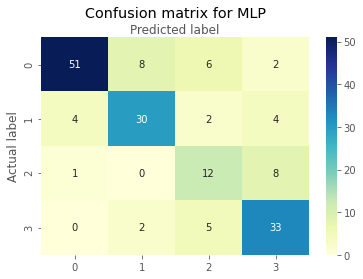

In [ ]:
heat_map(con_matrix_lr, "MLP")

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score
clf = svm.SVC(kernel='linear', C=1)
predicted_lr = clf.fit(X_train,y_train).predict(X_test)

classification report for SVM
              precision    recall  f1-score   support

       angry       0.86      0.75      0.80        67
         sad       0.51      0.53      0.52        40
     neutral       0.42      0.38      0.40        21
       happy       0.54      0.68      0.60        40

    accuracy                           0.63       168
   macro avg       0.58      0.58      0.58       168
weighted avg       0.65      0.63      0.64       168



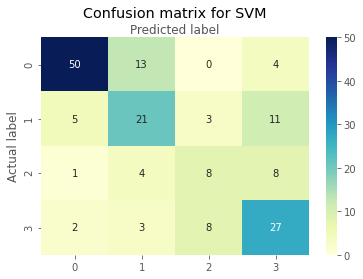

In [ ]:
con_matrix_lr = metrics.confusion_matrix(y_test, predicted_lr)
report_SVM = metrics.classification_report(y_test, predicted_lr, target_names = target_names)
print("classification report for SVM")
print(report_SVM)
heat_map(con_matrix_lr, "SVM")

classification report for Naive Bayes:
              precision    recall  f1-score   support

       angry       0.87      0.40      0.55        67
         sad       0.47      0.23      0.31        40
     neutral       0.27      0.95      0.42        21
       happy       0.14      0.15      0.14        40

    accuracy                           0.37       168
   macro avg       0.44      0.43      0.36       168
weighted avg       0.53      0.37      0.38       168



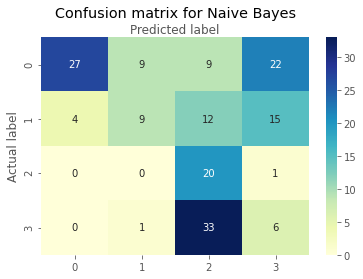

In [ ]:
from sklearn.naive_bayes import GaussianNB 
NB = GaussianNB() 
predicted_NB = NB.fit(X_train, y_train).predict(X_test)
con_matrix_NB = metrics.confusion_matrix(y_test, predicted_NB)
report_NB = metrics.classification_report(y_test, predicted_NB, target_names = target_names)
print("classification report for Naive Bayes:")
print(report_NB)
heat_map(con_matrix_NB, "Naive Bayes")

classification report for Logistic
              precision    recall  f1-score   support

       angry       0.87      0.78      0.82        67
         sad       0.56      0.45      0.50        40
     neutral       0.41      0.43      0.42        21
       happy       0.52      0.70      0.60        40

    accuracy                           0.64       168
   macro avg       0.59      0.59      0.58       168
weighted avg       0.65      0.64      0.64       168



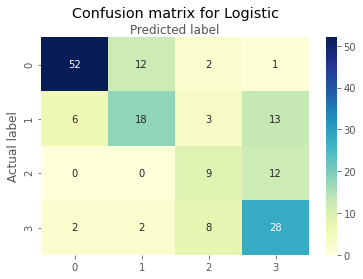

In [ ]:
from sklearn.linear_model import LogisticRegression
multireg = LogisticRegression(solver='liblinear')
predicted_lr = multireg.fit(X_train, y_train).predict(X_test)
con_matrix_lr = metrics.confusion_matrix(y_test, predicted_lr)
report_lr = metrics.classification_report(y_test, predicted_lr, target_names = target_names)
print("classification report for Logistic")
print(report_lr)
heat_map(con_matrix_lr, "Logistic")

['sad' 'angry' 'happy' 'happy' 'angry' 'angry' 'angry' 'angry' 'sad'
 'neutral' 'neutral' 'neutral' 'sad' 'neutral' 'happy' 'neutral' 'sad'
 'angry' 'happy' 'happy' 'happy' 'neutral' 'neutral' 'happy' 'neutral'
 'angry' 'sad' 'happy' 'neutral' 'angry' 'happy' 'angry' 'happy' 'angry'
 'sad' 'sad' 'angry' 'angry' 'angry' 'sad' 'happy' 'happy' 'angry' 'sad'
 'angry' 'neutral' 'sad' 'neutral' 'neutral' 'sad' 'neutral' 'happy'
 'happy' 'angry' 'sad' 'angry' 'angry' 'happy' 'happy' 'angry' 'sad'
 'happy' 'neutral' 'sad' 'sad' 'neutral' 'sad' 'angry' 'sad' 'angry'
 'happy' 'happy' 'happy' 'angry' 'angry' 'neutral' 'angry' 'happy' 'happy'
 'angry' 'happy' 'neutral' 'sad' 'angry' 'neutral' 'happy' 'neutral'
 'angry' 'sad' 'happy' 'sad' 'neutral' 'angry' 'angry' 'neutral' 'angry'
 'angry' 'sad' 'sad' 'sad' 'neutral' 'sad' 'angry' 'happy' 'sad' 'angry'
 'angry' 'angry' 'happy' 'sad' 'happy' 'happy' 'happy' 'happy' 'happy'
 'neutral' 'angry' 'angry' 'sad' 'sad' 'happy' 'sad' 'angry' 'sad' 'angry'


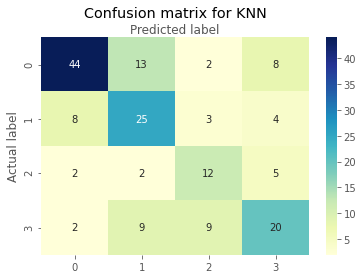

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
con_matrix_KNN = confusion_matrix(y_test, y_pred)
print("classification report for KNN")
print(classification_report(y_test, y_pred))

heat_map(con_matrix_KNN, "KNN")

In [ ]:
from sklearn import mixture
model1 = mixture.GaussianMixture(n_components=4, covariance_type='full')
gmm = model1.fit(X_train,y_train)
y_pred = gmm.predict(X_test)
print(y_test)
# con_matrix_GMM = confusion_matrix(y_test, y_pred)
# report_GMM = classification_report(Y, labels, target_names = target_names)
# print("classification report for GMM")
# print(report_GMM)
# heat_map(con_matrix_lr, "GMM")

['sad', 'angry', 'happy', 'happy', 'angry', 'angry', 'happy', 'angry', 'angry', 'sad', 'sad', 'neutral', 'neutral', 'neutral', 'happy', 'neutral', 'happy', 'angry', 'sad', 'happy', 'happy', 'angry', 'neutral', 'happy', 'neutral', 'sad', 'angry', 'angry', 'neutral', 'angry', 'sad', 'happy', 'happy', 'angry', 'neutral', 'angry', 'happy', 'angry', 'angry', 'sad', 'sad', 'angry', 'angry', 'sad', 'neutral', 'sad', 'sad', 'neutral', 'neutral', 'sad', 'sad', 'sad', 'happy', 'happy', 'angry', 'angry', 'angry', 'happy', 'happy', 'angry', 'neutral', 'happy', 'happy', 'sad', 'angry', 'neutral', 'neutral', 'angry', 'sad', 'angry', 'sad', 'happy', 'sad', 'angry', 'angry', 'angry', 'angry', 'happy', 'happy', 'angry', 'sad', 'sad', 'sad', 'angry', 'sad', 'happy', 'sad', 'happy', 'sad', 'angry', 'sad', 'sad', 'angry', 'angry', 'happy', 'angry', 'angry', 'sad', 'sad', 'happy', 'neutral', 'sad', 'angry', 'happy', 'sad', 'angry', 'angry', 'angry', 'angry', 'sad', 'angry', 'angry', 'angry', 'happy', 'angr